In [4]:
import numpy as np
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import fetch_covtype
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.io import arff
import sklearn as sk
import time
from sklearn.datasets import fetch_openml

In [33]:
%run 'common.ipynb'

In [5]:
def get_anomaly_X_y_from_csv(csv_file, main_labels, target_column):
    df=pd.read_csv(os.path.join(output_folder, csv_file),usecols=main_labels)
    df=df.fillna(0)
    anomaly_or_not=[]
    for i in df[TARGET_COLUMN]: #it changes the normal label to "1" and the anomaly tag to "0" for use in the machine learning algorithm
        if i == normal_target:
            anomaly_or_not.append(1)
        else:
            anomaly_or_not.append(0)           
    df[target_column]=anomaly_or_not

    y = df[target_column].values
    del df[target_column]
    X = df.values
    
    X = np.float32(X)
    X[np.isnan(X)] = 0
    X[np.isinf(X)] = 0
    # print('X', type(X), X)
    # print('y', type(y), y)
    return (X, y, df)

In [ ]:
# Create a folder to save the CSVs
remove_files_from_directory(OUTPUT_FOLDER)
remove_files_from_directory(FEATURE_FOLDER)
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
os.makedirs(FEATURE_FOLDER, exist_ok=True)

In [23]:
# Define variables
NORMAL_TARGET = 2
OUTPUT_FOLDER = 'csv_files'
TARGET_COLUMN = 'Cover_Type'
FEATURE_FOLDER = 'features'
TEST_COUNT = 500

# List of target class names
TARGET_DICT = {
    1: "Spruce-Fir",
    2: "LodgepolePine",
    3: "PonderosaPine",
    4: "CottonwoodWillow",
    5: "Aspen",
    6: "DouglasFir",
    7: "Krummholz"
}

INV_TARGET_DICT = {
    "Spruce-Fir": 1,
    "LodgepolePine": 2,
    "PonderosaPine": 3,
    "CottonwoodWillow": 4,
    "Aspen": 5,
    "DouglasFir": 6,
    "Krummholz": 7,
}

In [8]:
data = fetch_covtype(as_frame=True)  # Set as_frame=True to get the data as a DataFrame
X_data = data['data']
y_data = data['target']

# Combine features and target into one DataFrame
all_df = pd.concat([X_data, y_data], axis=1)

print('Normal class: ', all_df[TARGET_COLUMN].mode())
print('Feature  names: ', data.feature_names)
all_df.head()

Normal class:  0    2
Name: Cover_Type, dtype: int32
Feature  names:  ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23', 'Soil_Type_24', 'Soil_Type_25', 'Soil_Type_26', 'Soil_Type_27', 'Soil_Type_28', 'Soil_Type_29', 'Soil_Type_30', 'Soil_Type_31', 'Soil_Type_32', 'Soil_Type_33', 'Soil_Type_34', 'Soil_Type_35', 'Soil_Type_36', 'Soil_Type_37', 'Soil_Type_38', 'Soi

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


In [15]:
# Get X and y from all_df
X_df = all_df.drop(columns=[TARGET_COLUMN])
y_df = all_df[TARGET_COLUMN]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_df.values, y_df.values, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Convert X_train and y_train to DataFrame and Series respectively
X_train_df = pd.DataFrame(X_train, columns=X_df.columns)  # Assuming X_df has the column names
y_train_df = pd.Series(y_train, name=TARGET_COLUMN)  # Convert y_train to a Series with the target column name

# Concatenate X_train and y_train along the columns (axis=1)
X_y_train_df = pd.concat([X_train_df, y_train_df], axis=1)
X_y_train_df.head()

(464809, 54) (116203, 54) (464809,) (116203,)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
0,3289.0,22.0,19.0,240.0,93.0,1708.0,205.0,196.0,122.0,2598.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,2963.0,21.0,18.0,134.0,27.0,1243.0,206.0,200.0,127.0,1140.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,3037.0,185.0,9.0,127.0,10.0,6462.0,222.0,246.0,158.0,3037.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,3113.0,203.0,13.0,190.0,22.0,2125.0,213.0,251.0,171.0,730.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,3128.0,346.0,9.0,120.0,36.0,552.0,203.0,226.0,161.0,924.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [16]:
# Loop through each cover type and create a dataset
for label, name in TARGET_DICT.items():
    # 30% of the current cover type
    class_data = X_y_train_df[X_y_train_df[TARGET_COLUMN] == label]
    class_sample = class_data.sample(frac=0.30, random_state=42)

    # 70% of normal data (from other cover types)
    normal_data = X_y_train_df[X_y_train_df[TARGET_COLUMN] != label]
    normal_sample = normal_data.sample(n=len(class_sample) * (7 // 3), random_state=42)

    # Combine the class and normal data
    combined_data = pd.concat([class_sample, normal_sample])

    # Save the dataset to CSV
    path = os.path.join(OUTPUT_FOLDER, f"{name}.csv")
    combined_data.to_csv(path, index=False)
    print(f"{name}.csv created with {len(combined_data)} rows.")

print("All datasets created successfully!")

Spruce-Fir.csv created with 152355 rows.
LodgepolePine.csv created with 204120 rows.
PonderosaPine.csv created with 25770 rows.
CottonwoodWillow.csv created with 1998 rows.
Aspen.csv created with 6747 rows.
DouglasFir.csv created with 12489 rows.
Krummholz.csv created with 14844 rows.
All datasets created successfully!


csv_files ['Krummholz.csv', 'CottonwoodWillow.csv', 'DouglasFir.csv', 'Aspen.csv', 'LodgepolePine.csv', 'Spruce-Fir.csv', 'PonderosaPine.csv']
csv file Krummholz.csv
importances [4.78420871e-01 3.57765902e-02 2.52750161e-02 5.65813736e-02
 4.10273548e-02 8.71176706e-02 3.16103967e-02 4.62797393e-02
 3.13660021e-02 7.59246210e-02 4.88320446e-03 4.13161375e-03
 4.46895524e-03 6.01949838e-04 2.32523255e-06 9.30802916e-03
 7.34360614e-04 1.04314108e-02 4.40856394e-05 1.12023396e-04
 9.60025999e-07 4.53097130e-06 1.13663351e-04 1.43953524e-03
 1.60881111e-03 3.54769143e-03 2.48807732e-03 0.00000000e+00
 0.00000000e+00 3.94335202e-04 1.66776921e-03 1.74525202e-04
 4.52690958e-04 1.57244441e-03 1.16036573e-04 4.19937574e-03
 6.96591334e-03 2.69683110e-03 2.73255089e-04 2.57308964e-04
 5.82736613e-04 2.53087738e-04 7.42458567e-03 1.94099752e-03
 3.22903025e-03 9.10352191e-03 3.95116748e-03 2.95281669e-04
 4.00457432e-06 1.69801126e-04 0.00000000e+00 2.08769057e-04
 5.44337843e-04 2.21330042e-0

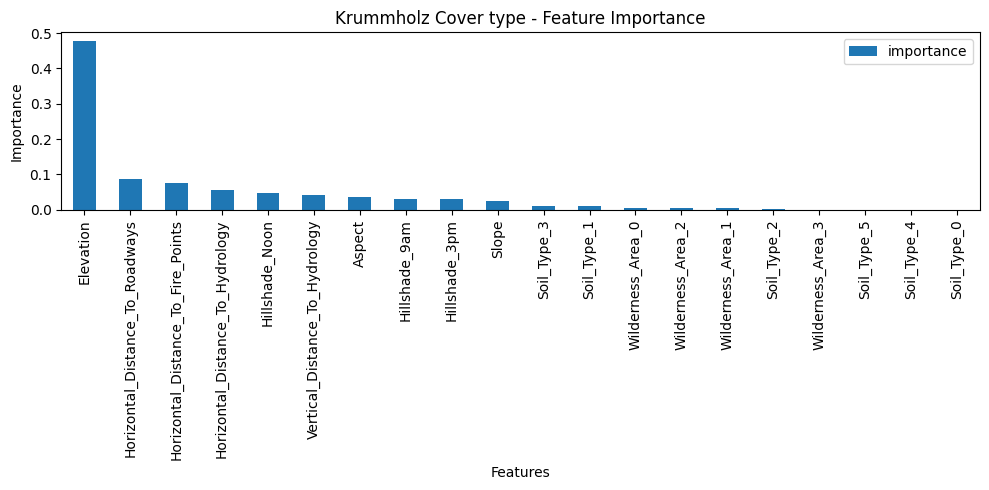

-----------------------------------------------------------------------------------------------




csv file CottonwoodWillow.csv
importances [4.81199654e-01 4.15453597e-02 3.05407975e-02 5.26694815e-02
 4.56907914e-02 7.67634716e-02 3.29010718e-02 5.03736841e-02
 3.36124775e-02 6.20668270e-02 6.32272280e-03 1.47081341e-03
 4.38275441e-03 8.51772773e-03 0.00000000e+00 7.36084909e-03
 2.35508521e-04 1.03015319e-03 1.85024856e-04 3.84325782e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.89958809e-03
 1.27584543e-03 6.59256277e-03 2.92560502e-03 6.95488722e-06
 0.00000000e+00 2.65957890e-04 4.85728479e-03 1.71046512e-05
 2.12340000e-03 2.27538111e-03 1.44080317e-04 3.01830028e-03
 6.01875995e-03 3.66932555e-03 0.00000000e+00 7.53794041e-04
 1.31442150e-03 4.43984214e-06 5.43923097e-03 1.98335108e-03
 2.43103287e-03 9.30179588e-03 4.87131915e-03 2.27820482e-05
 1.67377317e-05 0.00000000e+00 0.00000000e+00 1.27952495e-04
 3.55195535e-04 3.42999581e-05] CottonwoodWillow
important_featur

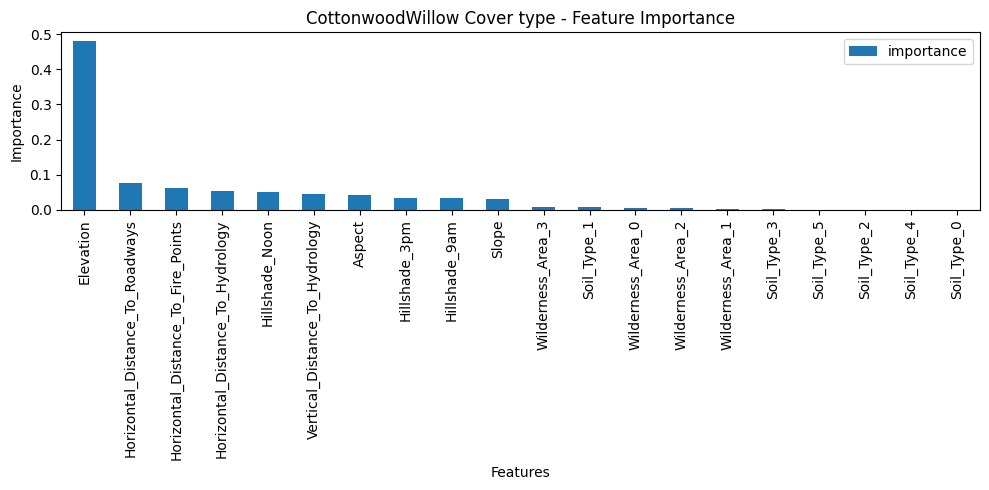

-----------------------------------------------------------------------------------------------




csv file DouglasFir.csv
importances [4.00914916e-01 4.21223539e-02 2.70513580e-02 5.73257888e-02
 4.95195032e-02 9.84839698e-02 3.47012581e-02 4.43685037e-02
 3.66917587e-02 8.86938181e-02 3.67995000e-02 2.77608664e-03
 1.33024629e-02 8.57703757e-04 5.26531101e-06 1.26211288e-03
 2.50548039e-03 8.52032016e-04 2.38753610e-06 1.58986994e-04
 0.00000000e+00 3.15520270e-06 1.79015168e-04 2.66820093e-03
 6.51711566e-03 6.59949515e-04 3.76465893e-03 3.98130795e-06
 0.00000000e+00 6.25979906e-04 5.58091573e-04 1.62000646e-05
 4.11502865e-04 1.36448265e-03 2.39643281e-04 6.07274440e-03
 6.66412312e-03 5.17659797e-03 7.37806327e-05 1.95113169e-04
 4.29197426e-04 7.66617350e-04 6.34958553e-03 1.87507094e-03
 3.94552064e-03 6.33517393e-03 4.70691510e-03 9.57560192e-04
 5.01348570e-05 1.60843744e-04 0.00000000e+00 3.05959186e-04
 3.47202241e-04 1.80635922e-04] DouglasFir
important_features ['Elevati

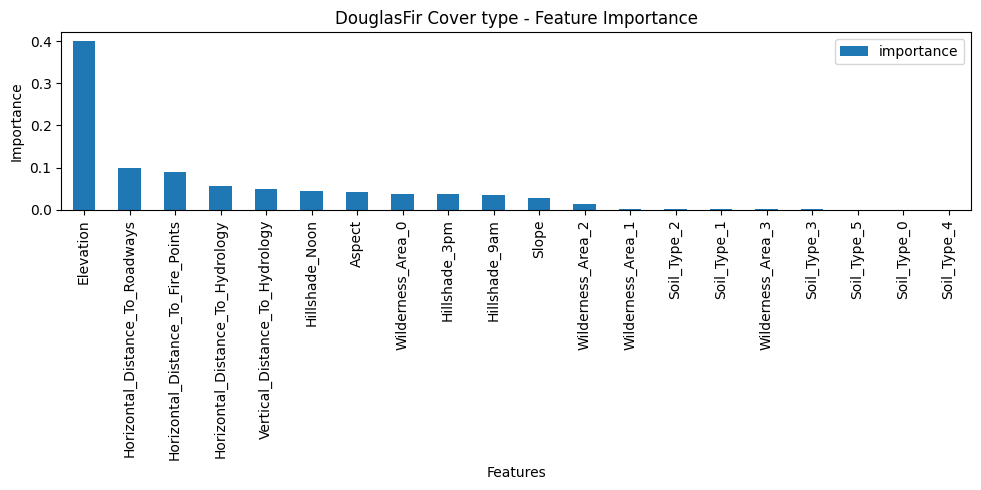

-----------------------------------------------------------------------------------------------




csv file Aspen.csv
importances [1.85374686e-01 5.69502863e-02 3.94533059e-02 6.92912421e-02
 6.15279498e-02 1.48615998e-01 4.99919619e-02 6.30618623e-02
 5.17328329e-02 1.12140599e-01 1.05485234e-02 2.00927290e-03
 7.55667121e-03 5.73605592e-04 1.16855709e-05 6.55839712e-04
 9.01719204e-04 3.60051260e-03 4.77108267e-06 4.59542385e-04
 8.41266184e-06 1.01236197e-04 4.87330934e-04 4.78226428e-03
 3.48747478e-03 4.77908324e-02 3.15044426e-03 1.34393074e-06
 0.00000000e+00 1.14348321e-03 7.44521513e-04 2.04061029e-04
 6.05407137e-04 1.76865410e-03 1.91303555e-04 4.21019516e-03
 1.31390343e-02 4.83062492e-03 3.02025955e-05 1.39556161e-03
 5.18091862e-05 1.38933406e-03 1.67115262e-02 4.98990826e-03
 6.99486175e-03 8.51312681e-03 5.99310061e-03 1.52126456e-03
 5.14360215e-06 0.00000000e+00 4.26856381e-06 3.46669850e-04
 6.24597701e-04 3.19132501e-04] Aspen
important_features ['Elevation', 'Hori

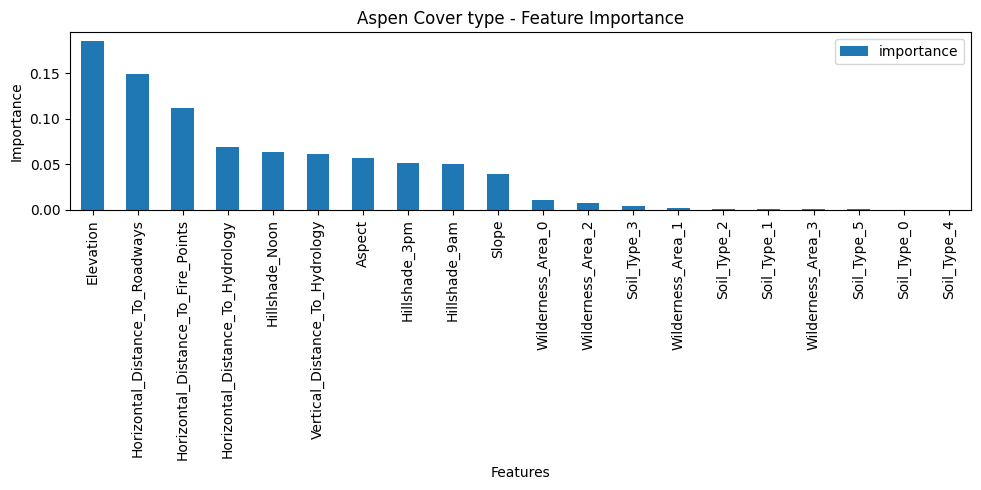

-----------------------------------------------------------------------------------------------




csv file LodgepolePine.csv
importances [3.03977545e-01 3.44124123e-02 2.21732441e-02 6.74637165e-02
 5.35738828e-02 1.46128811e-01 3.25070176e-02 4.06886375e-02
 2.97622062e-02 1.41371105e-01 9.94985378e-03 2.75536052e-03
 6.40400736e-03 7.23030135e-04 3.27770356e-06 9.33760013e-03
 5.32918197e-04 9.26901962e-03 5.78075739e-06 1.60040606e-04
 1.11308400e-06 6.25959210e-05 2.47665077e-04 3.36866647e-03
 2.44897301e-03 1.55477427e-02 3.33142260e-03 7.34745264e-07
 0.00000000e+00 1.07151291e-03 1.68689537e-03 2.64864015e-05
 1.03144642e-03 2.15776450e-03 2.06938080e-04 7.85165687e-03
 9.85617616e-03 5.25182671e-03 6.91742840e-05 2.90845208e-04
 1.32287762e-03 2.86501192e-04 6.42987950e-03 3.37435551e-03
 6.07149784e-03 9.26367925e-03 6.08925869e-03 5.03573179e-04
 9.66039007e-06 4.37854462e-05 0.00000000e+00 2.60933136e-04
 4.15174145e-04 2.19720878e-04] LodgepolePine
important_features ['E

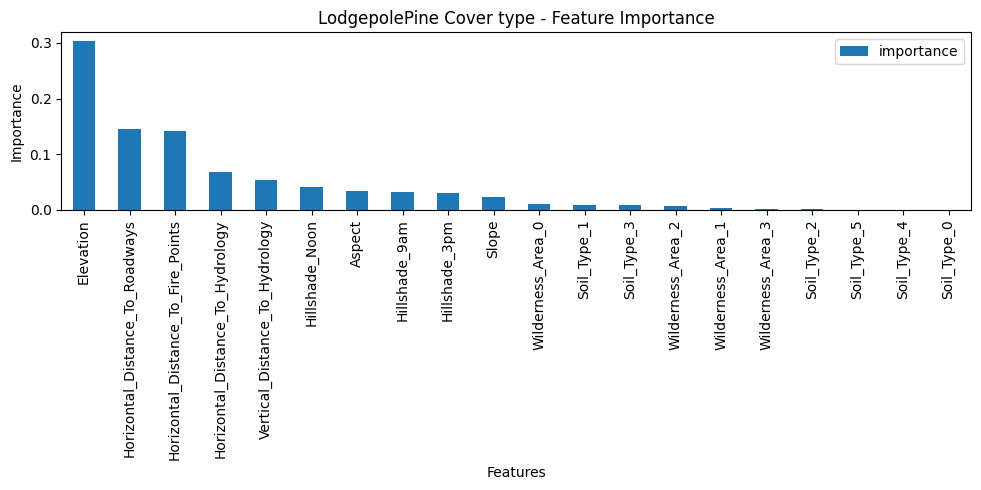

-----------------------------------------------------------------------------------------------




csv file Spruce-Fir.csv
importances [3.41859048e-01 3.33884643e-02 2.12030275e-02 6.31922019e-02
 5.02375049e-02 1.34615688e-01 3.23746617e-02 4.24190995e-02
 2.93371260e-02 1.31780110e-01 8.11763531e-03 4.18645229e-03
 6.44741484e-03 9.11323172e-04 6.05730547e-06 1.03177426e-02
 3.81890818e-04 1.05033518e-02 8.48769376e-06 1.98953256e-04
 3.73990891e-07 4.99887544e-05 1.93842672e-04 3.64501235e-03
 1.75265591e-03 4.67897997e-03 3.70652406e-03 3.15266234e-07
 0.00000000e+00 1.20644038e-03 1.51330661e-03 3.08030399e-05
 1.05846281e-03 2.17125129e-03 3.83907158e-04 6.89248959e-03
 8.80970307e-03 4.95206290e-03 8.25046669e-05 1.68684940e-04
 1.20781737e-03 1.87640542e-04 7.74063587e-03 2.74430071e-03
 5.60520510e-03 1.15450425e-02 6.22551047e-03 2.71545141e-04
 2.76531814e-05 1.29561962e-04 0.00000000e+00 3.75684700e-04
 7.97178123e-04 3.58673358e-04] Spruce-Fir
important_features ['Elevati

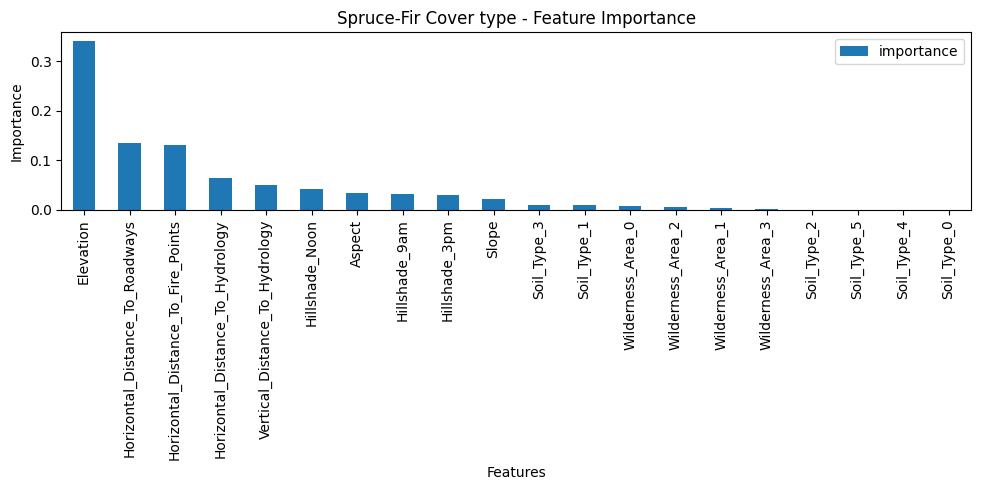

-----------------------------------------------------------------------------------------------




csv file PonderosaPine.csv
importances [3.69965546e-01 3.75277164e-02 2.62888738e-02 5.73420932e-02
 4.43091305e-02 9.76798710e-02 3.18551354e-02 4.61958168e-02
 3.20535107e-02 9.14656940e-02 4.23792179e-02 3.14086704e-03
 5.11932354e-03 9.59200188e-04 3.61894187e-06 2.25905238e-02
 5.55650713e-04 2.55854837e-02 2.20613203e-06 9.94791880e-05
 0.00000000e+00 1.18338495e-06 5.58781909e-05 3.58849406e-03
 5.14429303e-03 4.50163823e-03 2.27952926e-03 3.41307325e-07
 0.00000000e+00 7.50072867e-04 1.45625174e-03 5.02970377e-05
 5.88981021e-04 1.53095253e-03 1.58382254e-04 6.20144448e-03
 5.83167224e-03 3.36775813e-03 1.36151370e-04 2.53239505e-04
 7.06952595e-04 8.26653442e-05 5.92498711e-03 1.90350886e-03
 4.68937163e-03 8.09636242e-03 6.09818490e-03 3.44978710e-04
 1.13848002e-05 7.20771564e-05 0.00000000e+00 4.07657407e-04
 4.65763365e-04 1.80586365e-04] PonderosaPine
important_features ['E

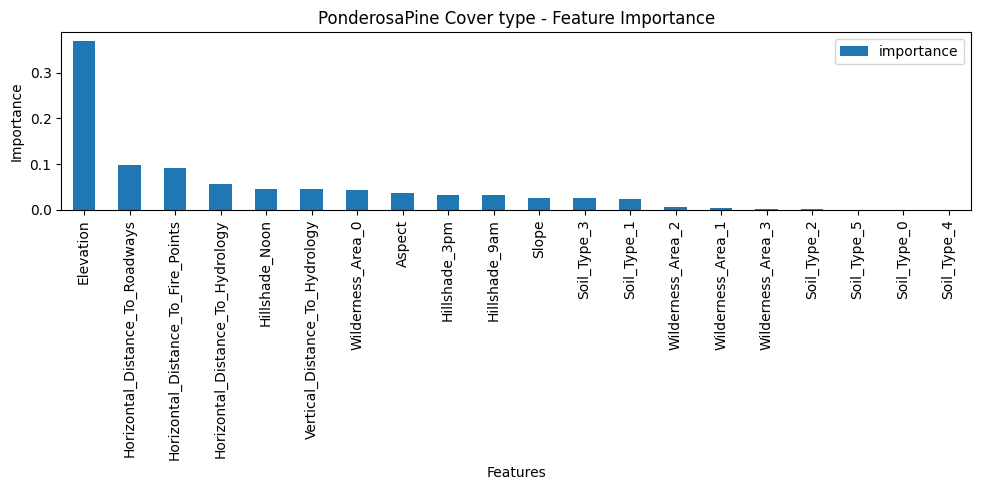

-----------------------------------------------------------------------------------------------




feature_importances {'Krummholz': ['Elevation', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points', 'Horizontal_Distance_To_Hydrology', 'Hillshade_Noon'], 'CottonwoodWillow': ['Elevation', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points', 'Horizontal_Distance_To_Hydrology', 'Hillshade_Noon'], 'DouglasFir': ['Elevation', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology'], 'Aspen': ['Elevation', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points', 'Horizontal_Distance_To_Hydrology', 'Hillshade_Noon'], 'LodgepolePine': ['Elevation', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology'], 'Spruce-Fir': ['Elevation', 'Horizontal_Distance_To_Roadways', '

In [17]:
seconds = time.time()

# CSV files names:
csv_files=os.listdir(OUTPUT_FOLDER)# It creates a list of file names in the "attacks" folder.
print('csv_files',csv_files)

# Headers of column
main_labels=data.feature_names[:]
main_labels.append(TARGET_COLUMN)

ths = open("importance_list.csv", "w")
feature_importances = {}
SVMs = {}
for csv_file in csv_files:
    print('csv file', csv_file)
    
    X, y, df = get_anomaly_X_y_from_csv(csv_file, main_labels, TARGET_COLUMN)

    #computing the feature importances
    forest = sk.ensemble.RandomForestRegressor(n_estimators=250,random_state=0)
    forest.fit(X, y)
    importances = forest.feature_importances_
    label = csv_file.split(".")[0]
    print('importances', importances, label)
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    refclasscol=list(df.columns.values)
    impor_bars = pd.DataFrame({'Features':refclasscol[0:20],'importance':importances[0:20]})
    impor_bars = impor_bars.sort_values('importance',ascending=False)
    important_features = impor_bars['Features'].to_list()[:5]
    impor_bars = impor_bars.set_index('Features')
    print('important_features', important_features)
    feature_importances[label] = important_features

    svm = SVC()
    X_train_class = df.iloc[:, df.columns.get_indexer(important_features)]
    # print('X_train_class', X_train_class)
    y_train_class = y
    # print('y_train_class', y_train_class)
    if len(y_train_class) > 0:  # Ensure there are samples for this class
        svm.fit(X_train_class, y_train_class)
    else:
        print(f'no data for {label}')
    SVMs[label] = svm

    
    plt.rcParams['figure.figsize'] = (10, 5)
    impor_bars.plot.bar();
    #printing the feature importances  
    count=0
    fea_ture=label+"=["
    for i in impor_bars.index:
        fea_ture=fea_ture+"\""+str(i)+"\","
        count+=1
        if count==5:
            fea_ture=fea_ture[0:-1]+"]"
            break     
    print(label,"importance list:")
    print(label,"\n",impor_bars.head(20),"\n\n\n")
    print(fea_ture)
    plt.title(label+" Cover type - Feature Importance")
    plt.ylabel('Importance')
    plt.savefig(os.path.join(FEATURE_FOLDER, label+".pdf"),bbox_inches='tight', format = 'pdf')
    ths.write((  fea_ture ) )
    plt.tight_layout()
    plt.show()
    print("-----------------------------------------------------------------------------------------------\n\n\n\n")

print('feature_importances', feature_importances)
print("mission accomplished!")
print("Total operation time: = ",time.time()- seconds ,"seconds")
ths.close()



In [20]:
# Step 1: Train KNN to classify
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Step 2: Predict classes for the test set
X_test = X_test[:TEST_COUNT]
y_test = y_test[:TEST_COUNT]
knn_predictions = knn.predict(X_test)
print('knn_predictions', knn_predictions)

knn_predictions [1 2 2 2 2 3 2 1 2 2 2 1 5 2 2 1 2 5 3 2 1 2 2 1 6 1 1 2 1 2 1 2 2 3 2 2 2
 2 2 1 2 1 1 2 2 1 2 1 7 2 1 1 6 2 1 1 7 2 2 2 2 1 1 2 2 2 3 2 2 1 5 1 2 3
 1 3 1 1 1 2 2 1 2 2 2 1 1 3 1 2 1 1 2 1 3 3 2 2 1 1 6 6 2 2 1 2 5 6 6 1 2
 1 2 1 1 1 3 1 2 3 1 1 1 1 2 2 1 1 1 2 1 2 2 2 5 1 1 1 2 3 1 2 2 3 1 1 1 2
 2 2 1 7 2 2 1 1 2 2 1 2 1 3 1 2 2 2 2 2 2 2 2 1 2 1 1 1 1 2 2 2 1 2 2 2 2
 2 1 2 2 1 1 1 2 2 1 3 3 2 1 1 2 7 1 1 1 1 2 2 2 3 2 2 3 6 2 1 2 1 2 2 3 1
 2 2 3 2 2 2 1 1 2 5 1 1 1 2 2 1 2 2 1 1 2 1 1 6 2 1 2 7 2 1 3 5 1 2 3 2 2
 1 2 2 1 2 2 2 2 1 1 2 1 2 1 1 2 6 1 3 2 7 1 1 2 2 2 2 2 2 7 1 1 1 1 1 2 2
 5 2 2 2 1 6 2 1 1 2 7 1 2 3 2 2 2 2 2 6 1 5 2 2 1 6 2 2 1 1 1 1 2 2 2 7 3
 3 2 1 2 2 2 3 2 2 1 2 1 1 2 1 7 2 1 3 3 5 2 2 1 3 3 2 2 1 2 2 2 2 2 2 1 2
 2 1 2 2 1 2 2 1 2 2 2 1 2 1 3 1 3 2 1 2 6 2 3 2 2 1 2 2 6 1 2 1 2 2 2 2 1
 2 2 7 2 2 5 1 2 1 1 2 2 2 1 7 1 2 2 1 6 2 2 1 1 2 2 2 6 2 2 5 1 6 1 1 2 1
 2 1 1 6 1 1 1 3 1 1 1 2 2 1 6 2 2 2 2 2 2 2 2 1 2 2 1 2 2 2 6 1 2 1 1 1 1
 2 7 1 1 

In [22]:
evaluate(y_test, knn_predictions, heading='-----KNN Evaluation-----')

-----KNN Evaluation-----
Confusion Matrix:
[[173   3   0   0   0   0   0]
 [  5 232   0   0   0   0   0]
 [  0   0  35   0   0   2   0]
 [  0   0   0   0   0   1   0]
 [  0   2   0   0  12   0   0]
 [  0   0   1   0   0  19   0]
 [  0   0   0   0   0   0  15]]

Classification Report:
              precision    recall  f1-score   support

           1       0.97      0.98      0.98       176
           2       0.98      0.98      0.98       237
           3       0.97      0.95      0.96        37
           4       0.00      0.00      0.00         1
           5       1.00      0.86      0.92        14
           6       0.86      0.95      0.90        20
           7       1.00      1.00      1.00        15

    accuracy                           0.97       500
   macro avg       0.83      0.82      0.82       500
weighted avg       0.97      0.97      0.97       500

Accuracy: 0.972


/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [25]:
svm_predictions = []

for i in range(X_test):
    test_instance = X_test[i].reshape(1, -1)
    predicted_label = TARGET_DICT[knn_predictions[i]]
    # print('predicted_label', predicted_label)
    selected_features = feature_importances[predicted_label]
    # print('selected_features', selected_features)
    svm_model = SVMs[predicted_label]
    
    # Select features for the SVM
    all_without_target_df = all_df.drop(columns=[TARGET_COLUMN])
    test_instance_selected = pd.DataFrame(
        test_instance[:, all_without_target_df.columns.get_indexer(selected_features)], 
        columns=selected_features
    )
    # print('test_instance_selected', test_instance_selected)
    
    svm_prediction = svm_model.predict(test_instance_selected)
    print('svm prediction: ', svm_prediction, 'knn prediction: ', INV_TARGET_DICT[predicted_label], 'actual value: ', y_test[i])
    svm_predictions.append((svm_prediction, INV_TARGET_DICT[predicted_label], y_test[i]))
# print(svm_predictions)

svm prediction:  [0] knn prediction:  1 actual value:  1
svm prediction:  [0] knn prediction:  2 actual value:  2
svm prediction:  [1] knn prediction:  2 actual value:  2
svm prediction:  [1] knn prediction:  2 actual value:  2
svm prediction:  [1] knn prediction:  2 actual value:  2
svm prediction:  [0] knn prediction:  3 actual value:  3
svm prediction:  [1] knn prediction:  2 actual value:  2
svm prediction:  [0] knn prediction:  1 actual value:  1
svm prediction:  [0] knn prediction:  2 actual value:  2
svm prediction:  [0] knn prediction:  2 actual value:  2
svm prediction:  [1] knn prediction:  2 actual value:  2
svm prediction:  [0] knn prediction:  1 actual value:  1
svm prediction:  [0] knn prediction:  5 actual value:  5
svm prediction:  [0] knn prediction:  2 actual value:  2
svm prediction:  [0] knn prediction:  2 actual value:  2
svm prediction:  [1] knn prediction:  1 actual value:  1
svm prediction:  [0] knn prediction:  2 actual value:  2
svm prediction:  [0] knn predic

In [34]:
# Now evaluate SVM predictions only for the anomalies detected by KNN
# Create a mask for test instances that KNN classified as anomalies
anomaly_mask = knn_predictions != NORMAL_TARGET  # Assuming normal_target is your normal class
print('anomaly_mask', len(anomaly_mask))

# Get true labels and predictions for anomalies
svm_predictions_actual = [t[1] for t in svm_predictions]
svm_predictions_actual = np.array(svm_predictions_actual)
print('svm_predictions_actual', len(svm_predictions_actual), svm_predictions_actual)
y_test_anomalies = y_test[anomaly_mask]
svm_predictions_anomalies = svm_predictions_actual[anomaly_mask]
print(len(y_test_anomalies), len(svm_predictions_anomalies))

# Evaluate SVM only on the anomalies
evaluate(y_test_anomalies, svm_predictions_anomalies, heading='SVM Evaluation (for anomalies)')

anomaly_mask 500 [ True False False False False  True False  True False False False  True
  True False False  True False  True  True False  True False False  True
  True  True  True False  True False  True False False  True False False
 False False False  True False  True  True False False  True False  True
  True False  True  True  True False  True  True  True False False False
 False  True  True False False False  True False False  True  True  True
 False  True  True  True  True  True  True False False  True False False
 False  True  True  True  True False  True  True False  True  True  True
 False False  True  True  True  True False False  True False  True  True
  True  True False  True False  True  True  True  True  True False  True
  True  True  True  True False False  True  True  True False  True False
 False False  True  True  True  True False  True  True False False  True
  True  True  True False False False  True  True False False  True  True
 False False  True False  True  Tr

/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [39]:
# def map_results(x, i, svm_predictions_actual, normal_class):
#     if x == normal_class:
#         return x
#     else:
#         return svm_predictions[i][1]
# cnt = 0
# all_predictions = []
# for x in knn_predictions:
#     all_predictions.append(map_results(x, cnt, svm_predictions_actual, NORMAL_TARGET))
#     if x != NORMAL_TARGET:
#         cnt += 1
# print('all_predictions', all_predictions)

evaluate(y_test, [t[1] for t in svm_predictions], heading='SVM Evaluation (for all)')

SVM Evaluation (for all)
Confusion Matrix:
[[173   3   0   0   0   0   0]
 [  5 232   0   0   0   0   0]
 [  0   0  35   0   0   2   0]
 [  0   0   0   0   0   1   0]
 [  0   2   0   0  12   0   0]
 [  0   0   1   0   0  19   0]
 [  0   0   0   0   0   0  15]]

Classification Report:
              precision    recall  f1-score   support

           1       0.97      0.98      0.98       176
           2       0.98      0.98      0.98       237
           3       0.97      0.95      0.96        37
           4       0.00      0.00      0.00         1
           5       1.00      0.86      0.92        14
           6       0.86      0.95      0.90        20
           7       1.00      1.00      1.00        15

    accuracy                           0.97       500
   macro avg       0.83      0.82      0.82       500
weighted avg       0.97      0.97      0.97       500

Accuracy: 0.972


/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera